          sample  sample_num seq_type  total_length_grt_0bp   
6        HG00733           6      asm          6.030233e+09  \
7    HG00733red1           6      asm          6.026941e+09   
9    HG00733red2           6      asm          6.027361e+09   
16       HG01573          11      asm          6.163712e+09   
18       HG00171          12      asm          6.115104e+09   
20       HG02587          13      asm          6.121212e+09   
22       HG01114          14      asm          6.149360e+09   
24       NA19036          16      asm          6.131558e+09   
28       NA19983          19      asm          6.138337e+09   
33       HG03683          23      asm          6.134663e+09   
38       HG01505          26      asm          5.956284e+09   
46       NA24385          34      asm          5.970087e+09   
50       HG02818          36      asm          6.106710e+09   
53       HG01352          39      asm          6.057193e+09   
56       HG02059          40      asm          5.920414

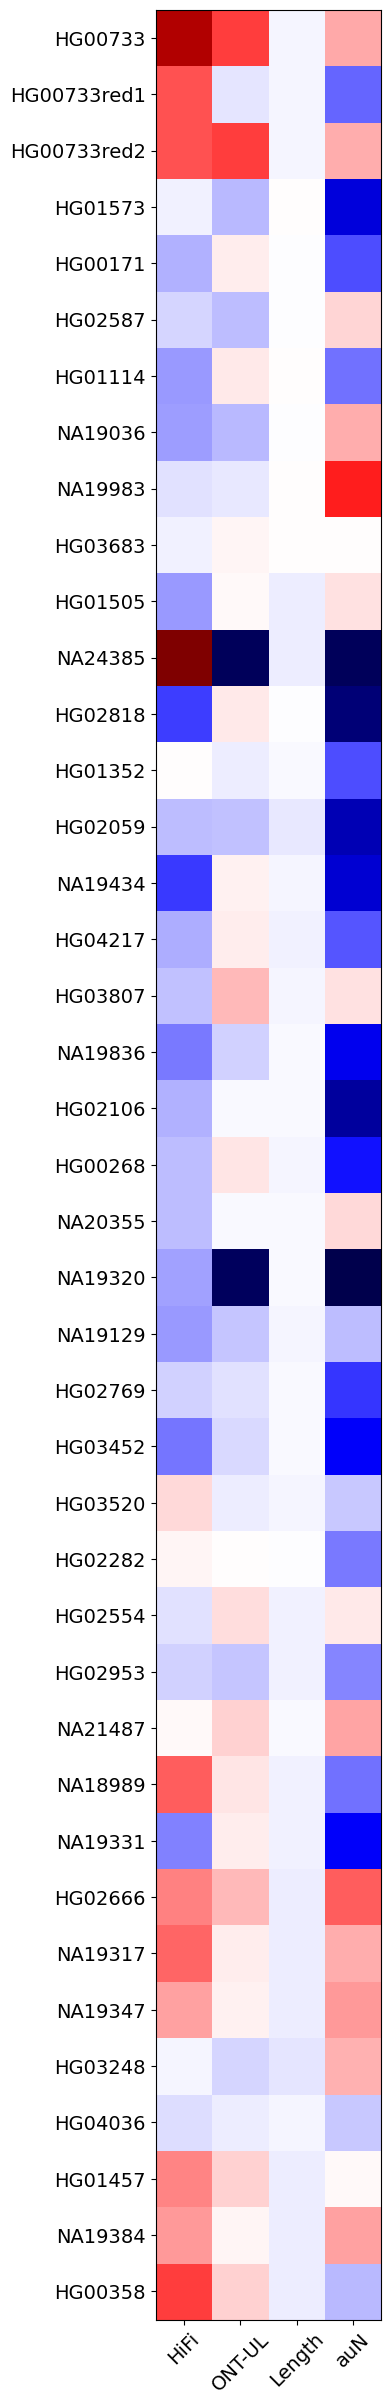

In [56]:
####
# Notebook used for plotting prelim. statistics presented at Glasgow meeting 2023
# - kept because of example for TwoSlopeNorm (relative color coding)
####


import pandas as pd
import pathlib as pl
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

all_stat_tables = pl.Path("../annotations").glob("*stats.tsv")

stats = None
for stat_table in all_stat_tables:
    if "hgsvc" in stat_table.name:
        continue
    df = pd.read_csv(stat_table, sep="\t", header=0)
    if stats is None:
        stats = df
    else:
        stats = stats.merge(df, how="outer", on=["sample", "sample_num"])
        
stats["seq_type"].fillna("n/a", inplace=True)
stats.fillna(0, inplace=True)
stats.sort_values(["sample_num", "sample"], inplace=True)

stats.reset_index(drop=True, inplace=True)

asm_stats = stats.loc[stats["seq_type"].isin(["asm"]), :].copy()


no_bmk_sample = ~asm_stats["sample"].isin(["NA24385", "HG00733", "HG00733red1", "HG00733red2"])

mean_hifi = asm_stats.loc[no_bmk_sample, "hifi_cov_at_3Gbp"].mean()
mean_ontul = asm_stats.loc[no_bmk_sample, "ontul_cov_at_3Gbp"].mean()

asm_stats["hifi_pct_mean"] = (asm_stats["hifi_cov_at_3Gbp"] / mean_hifi * 100).round(1)
asm_stats["ontul_pct_mean"] = (asm_stats["ontul_cov_at_3Gbp"] / mean_ontul * 100).round(1)

print(asm_stats)

center_sample = ((asm_stats["hifi_pct_mean"] + asm_stats["ontul_pct_mean"]) - 200).abs().idxmin()
print(asm_stats.loc[center_sample, :])

asm_stats["length_pct_center"] = (asm_stats["total_length_grt_0bp"] / asm_stats.loc[center_sample, "total_length_grt_0bp"] * 100).round(1)
asm_stats["auN_pct_center"] = (asm_stats["length_auN_grt_0bp"] / asm_stats.loc[center_sample, "length_auN_grt_0bp"] * 100).round(1)

plot_columns = [c for c in asm_stats.columns if "_pct_" in c]

asm_stats_plot = asm_stats[plot_columns]
print(asm_stats_plot.columns)
fig, ax = plt.subplots(figsize=(10, 30))

divnorm = colors.TwoSlopeNorm(
    vmin=asm_stats_plot.min(axis=0).min(),
    vcenter=100,
    vmax=asm_stats_plot.max(axis=1).max()
)

ax.imshow(
    asm_stats_plot,
    cmap="seismic",
    norm=divnorm
)
ax.tick_params(axis='y', labelrotation=0)
_ = ax.set_yticks(list(range(0, asm_stats.shape[0])))
_ = ax.set_yticklabels(asm_stats["sample"], fontsize=14)

_ = ax.set_xticks([0, 1, 2, 3])
_ = ax.set_xticklabels(["HiFi", "ONT-UL", "Length", "auN"], rotation=45, fontsize=14)

